In [28]:
from sklearn import preprocessing
import math,  requests
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import operator, itertools
import pandas as pd
import numpy as np
import seaborn as sns
import requests as rs
from matplotlib import pyplot as plt

    
### function that comper distribution of a column with and without log 
def log_comparison_graph(d,c, title):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].hist(d[c],bins=50,density=True,log=True)
    ax[1].hist(d[c],bins=50,density=True,log=False)
    
    ax[0].set_title(title + 'with log')
    ax[1].set_title(title +'without log')
    

    
### graph that compare distributions    
def make_destributionGraph_comper(y_test,y_pred, title):
    ### distribution of the actual bicycle density
    plt.figure(figsize=(8,5))
    y_test.hist(density=True,log=True,label='actual')
    ### distribution of the predict bicycle density
    plt.hist(y_pred,density=True,log=True,width = 3,label='predicted')
    plt.title("predict vs acutal for "+ title+ " density destributions")
    plt.legend(prop={'size': 10})
    

#### function for confution metrix    
def make_confution_matrix(y_test, y_pred,title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (20,15))
    plt.title('confution matrix for '+ title, fontsize=20)
    heatmap =  sns.heatmap(cm,annot=True,linewidths=.8)
    pre_rec = classification_report(y_test, y_pred, digits=3)
    return heatmap, pre_rec
    
    
### geting the columns for X for the naive bayes model
def get_x(data,cols):
    return data[cols]


## no need
#def get_y(data,s):
 #   t = ((data[s]-data[s].mean())/data[s].std())*-1
  #  return [int(i) for i in t.round(2)]

### function for accuracies graph comperison 
def make_graph_accuracies(accuracy, title):
    ratios = [str(i) for i in list(accuracy.keys())]
    accuracies = list(accuracy.values())
    plt.figure(figsize=(10,5))
    plt.grid(True)
    plt.plot(ratios, accuracies, 'y')
    plt.xticks(ratios)
    plt.xlabel('Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracies for given size for '+ title, fontsize=20)

#### function that adds a columns with log for giver columns
def add_log(data,need_to_log):
    newdata = data.copy()
    for col in need_to_log:
        newdata.loc[data[col]!=0,'log_'+col] = np.log(data.loc[data[col]!=0,col])
        newdata.loc[data[col]==0,'log_'+col] = 0
    return newdata


### function that creating the model
def create_naive_bayes_classifier(X, y):
    model = GaussianNB()
    model.fit(X, y)
    return model

### function that split the data into test and train for the NB model
def split_train_test(X, y, test_size):
    if test_size < 1 and test_size > 0:
        return train_test_split(X, y, test_size=test_size, random_state=0)
    else:
        print("Only numbers between 0-1")
        
### function that removes columns from the data        
def removeCols(data, remove):
    newdata = data.loc[:,[c for c in data.columns if c not in remove]]
    return newdata
    
    
#### function that round the number for 2 decimals after the point     
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

#### function that return a dict of the accuracies and their ratios
def best_ratio(X,y):
    ratios = np.arange(0.26, 0.36, 0.01)
    accuracy = {}
    for ratio in ratios:
        X_train, X_test, y_train, y_test = split_train_test(X, y,ratio)
        model = create_naive_bayes_classifier(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[round_up(ratio, 2)] = accuracy_score(y_test, y_pred)
    return accuracy

#### function that return the url with the information about the roads from the OSRM API
def get_url(start_lon, start_lat, finish_lon, finish_lat):
    loc = "{},{};{},{}".format(start_lon, start_lat, finish_lon, finish_lat)
    url = 'http://router.project-osrm.org/route/v1/driving/'
    url2 = "?overview=false"
    check = url + loc + url2
    return check

#### function that gets data with lat and lot and put them into the url in the function above and then extracts the distance  
def return_with_distances(data):
    for i,r in data.iterrows():
        t = data.loc[i,['s_lon','s_lat','e_lon','e_lat']]
        url = get_url(t[0],t[1],t[2],t[3])
        json = requests.get(url).json()
        data.loc[i,'distance'] = json['routes'][0]['distance']
        if i == 100: #### please noted that we stop the distances after 100 row in the data because it takes to long to check the full version. So just for the testing we tried 100, we will explain again in details later
            break
    
    return data


## pre-processing

In [2]:
## loading all the data and merging them into one dataframe

data_april = pd.read_csv("ICD_mobilty_full_apr_jer_v1.csv")
data_march = pd.read_csv("ICD_mobilty_full_mar_jer_v1.csv")
data_may = pd.read_csv("ICD_mobilty_full_may_jer_v1.csv")
data_full = pd.concat([data_march,data_april,data_may],ignore_index = True)
cols = list(data_full.columns)

In [3]:
### checking for NA obs
data_full.isna().sum()

average_speed                       0
bicycle_density                     0
bicycle_detections_count            0
day_of_week                         0
hour                                0
month                               0
pedestrian_density                  0
pedestrian_detections_count         0
segment_id                          0
speed-speed_denominator        101691
year                                0
s_lon                               0
s_lat                               0
e_lon                               0
e_lat                               0
speed_drives_count             211385
dtype: int64

In [4]:

### deleting unnecessary columns for the project 
remove = ["average_speed","speed_drives_count","speed-speed_denominator",'pedestrian_detections_count','bicycle_detections_count']
new_data = removeCols(data_full, remove)

### transform segment_id to numbers 
labelEncoder = preprocessing.LabelEncoder()
le_fitted = labelEncoder.fit_transform(new_data["segment_id"])
new_data["segment_id"] = le_fitted


### had distance column for every row(the function stops at 100 absarvation and not 300k because it takes to long),
### you can delete the "if" in the distance function to get the full solution but it take a lot of time so we put the mean distance to all the NA obs(will append in another section) just for testing the model
new_data = return_with_distances(new_data)




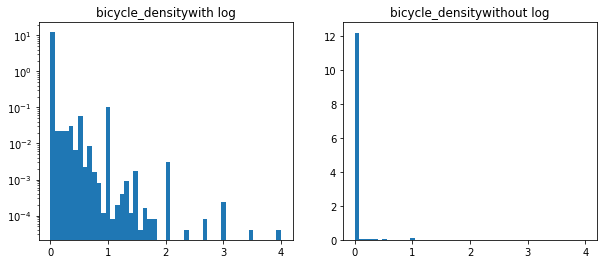

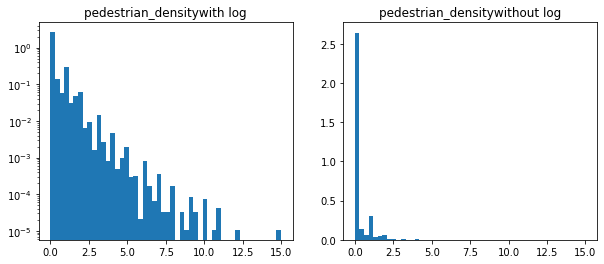

In [5]:
#### comparison of distribution for the Explained variables with anf without log function 

log_comparison_graph(new_data,"bicycle_density",'bicycle_density')
log_comparison_graph(new_data,"pedestrian_density",'pedestrian_density')

In [6]:
### had log to the prediction columns 
to_remove = [i for i in new_data.columns if 'pedest' in i or 'bicycle' in i]
new_data = add_log(new_data,to_remove)
new_data

,bicycle_density,day_of_week,hour,month,pedestrian_density,segment_id,year,s_lon,s_lat,e_lon,e_lat,distance,log_bicycle_density,log_pedestrian_density
0,0.0,4,6,3,0.000000,641,2020,35.214448,31.800676,35.214513,31.800631,7.9,0.0,0.000000
1,0.0,4,6,3,0.000000,641,2020,35.214513,31.800631,35.214636,31.800572,13.4,0.0,0.000000
2,0.0,4,6,3,0.000000,641,2020,35.214636,31.800572,35.214890,31.800499,25.3,0.0,0.000000
3,0.0,4,6,3,2.000000,2513,2020,35.219278,31.795478,35.219102,31.795688,509.9,0.0,0.693147
4,0.0,4,6,3,0.000000,306,2020,35.201871,31.779741,35.201886,31.780016,30.6,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313071,0.0,6,16,5,0.000000,1453,2020,35.240262,31.808248,35.240507,31.808208,NaN,0.0,0.000000
313072,0.0,6,14,5,0.000000,3500,2020,35.205905,31.803175,35.206416,31.802817,NaN,0.0,0.000000
313073,0.0,6,10,5,0.000000,1116,2020,35.206267,31.801124,35.206525,31.800969,NaN,0.0,0.000000
313074,0.0,6,7,5,0.333333,753,2020,35.198101,31.747350,35.198090,31.746484,NaN,0.0,-1.098612


## modeling

In [7]:
possible_y_labels = ['log_bicycle_density','log_pedestrian_density']

In [8]:
final = []
for i in range(len(possible_y_labels)):
    # part of the pre-proccesing, builing X,y combinations and math munipulation for the distrabution
    X = get_x(new_data,["year","month","day_of_week","hour","segment_id"])
    t = new_data[possible_y_labels[i]]
    # because we put log we got non positive numbers so we had to move the distribution to the right, now the min value is 0 
    #  + multiply by 10 (normlizing by multiply to catch all the destribution )--> math munipulation, we will reverse it later
    y = ((t + t.min()*-1)*10).astype('int')

    print('have X and y')
    
    print('finding best ratio')
    # compute accuracy scores for models with split ratio between 0.36-0.26 and finding the best
    accuracies = best_ratio(X,y)
    # this is the best ratio for off all the models
    br = max(accuracies, key=accuracies.get)
    print('best ratio is:',br)
    
    
    '''
    #modeling and predictions
    '''
    X_train, X_test, y_train, y_test = split_train_test(X,y,br)
    print('split train test finished')
    
    model = create_naive_bayes_classifier(X_train,y_train)
    y_pred = model.predict(X_test)
    print('predicted data')

    actual_data = X_test.copy()
    actual_data.loc[:,'y'] = y_test
    predicted_data = X_test.copy()
    predicted_data.loc[:,'y_pred'] = y_pred
    
    print('appending to list')    
    final.append({'accuracy':accuracies,'confusion':'t','data':[X_train, X_test, y_train, y_test,y_pred,actual_data,predicted_data],'model':model})
    print('finished')


have X and y
finding best ratio
best ratio is: 0.26
split train test finished
predicted data
appending to list
finished
have X and y
finding best ratio
best ratio is: 0.32
split train test finished
predicted data
appending to list
finished


In [9]:
### puting all the model information into the 2 diff models

log_bicycle_density_model = final[0]
log_pedestrian_density_model = final[1]


### model evaluation


In [10]:
### accuracy of the bicycle model
bicycle_acc = log_bicycle_density_model['accuracy'][max(accuracies)]
print('The accuracy score  of the bicycle model is: ' + str(bicycle_acc))

### accuracy of the pedestrian model
pedestrian_acc = log_pedestrian_density_model['accuracy'][max(accuracies)]
print('The accuracy score  of the pedestrian model is: ' + str(pedestrian_acc))

The accuracy score  of the bicycle model is: 0.9822316727050384
The accuracy score  of the pedestrian model is: 0.8711590936054099


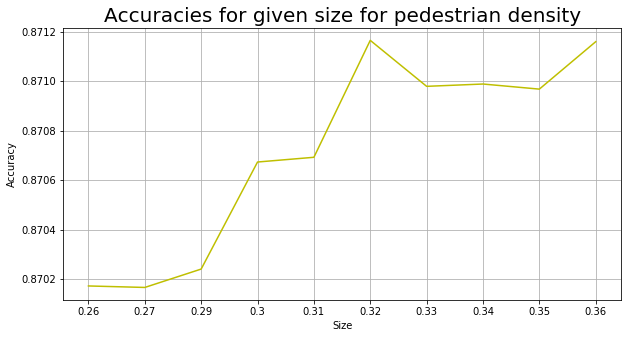

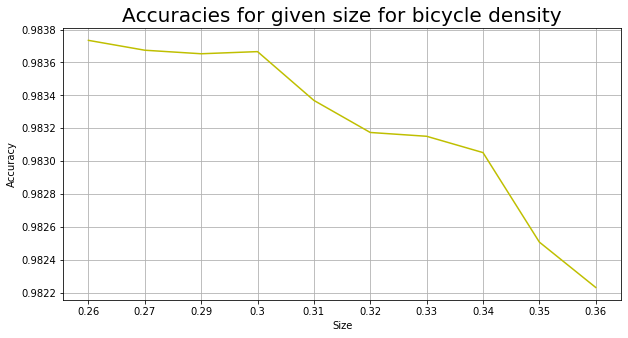

In [11]:
### plot of all the accuracies in the pedestrian model - between ratios of 0.26-0.36
make_graph_accuracies(log_pedestrian_density_model['accuracy'],'pedestrian density')
### plot of all the accuracies in the bicycle model - between ratios of 0.26-0.36
make_graph_accuracies(log_bicycle_density_model['accuracy'],'bicycle density')


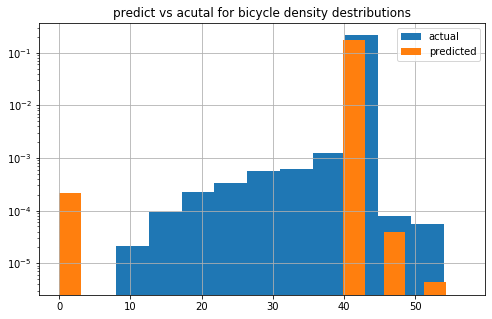

In [12]:
### comparison of destributions graph with the predicted and actual bicycle density
make_destributionGraph_comper(log_bicycle_density_model['data'][-4],log_bicycle_density_model['data'][-3],"bicycle")

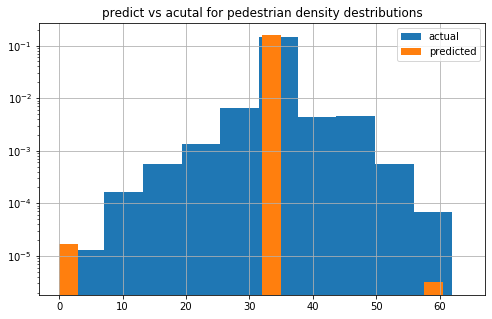

In [13]:
### comparison of destributions graph with the predicted and actual pedestrian density
make_destributionGraph_comper(log_pedestrian_density_model['data'][-4],log_pedestrian_density_model['data'][-3],'pedestrian')

In [14]:
### number of values in the actual log_pedestrian_density and the count of the obs that gets the value
log_pedestrian_density_model['data'][-4].value_counts()


37    87268
30     2813
44     1814
41     1013
26      835
33      831
40      593
23      410
48      402
34      381
42      377
39      364
46      302
32      256
35      237
21      231
28      213
43      188
51      135
19      121
47      104
45      104
38       99
36       98
29       96
50       83
25       82
18       77
16       60
53       59
49       55
22       49
31       45
15       41
27       40
52       37
14       35
13       29
11       28
20       21
55       21
24       20
9        17
57       14
54       13
12       12
10       11
17       11
56       10
58        7
59        6
8         5
7         4
60        3
4         2
62        1
6         1
1         1
Name: log_pedestrian_density, dtype: int64

In [15]:
### number of values in the predict log_pedestrian_density and the count of the obs that gets the value
log_pedestrian_density_model['data'][-1]['y_pred'].value_counts()

37    100172
0          7
4          4
64         2
Name: y_pred, dtype: int64

In [16]:
### number of values in the actual log_bicycle_density and the count of the obs that gets the value
log_bicycle_density_model['data'][-4].value_counts()

43    80191
36      371
32      182
29      118
27       72
39       59
25       52
23       38
34       34
20       26
21       24
22       22
19       20
50       20
30       18
47       17
16       15
18       13
38       13
40       11
46        8
14        7
31        7
28        7
41        7
26        6
17        6
24        5
13        5
12        4
33        4
35        4
15        3
37        2
45        2
11        2
9         1
54        1
48        1
49        1
8         1
Name: log_bicycle_density, dtype: int64

In [17]:
log_bicycle_density_model['data'][-1]['y_pred'].value_counts()

43    81280
5        88
49       17
3        10
57        2
0         2
51        1
Name: y_pred, dtype: int64

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


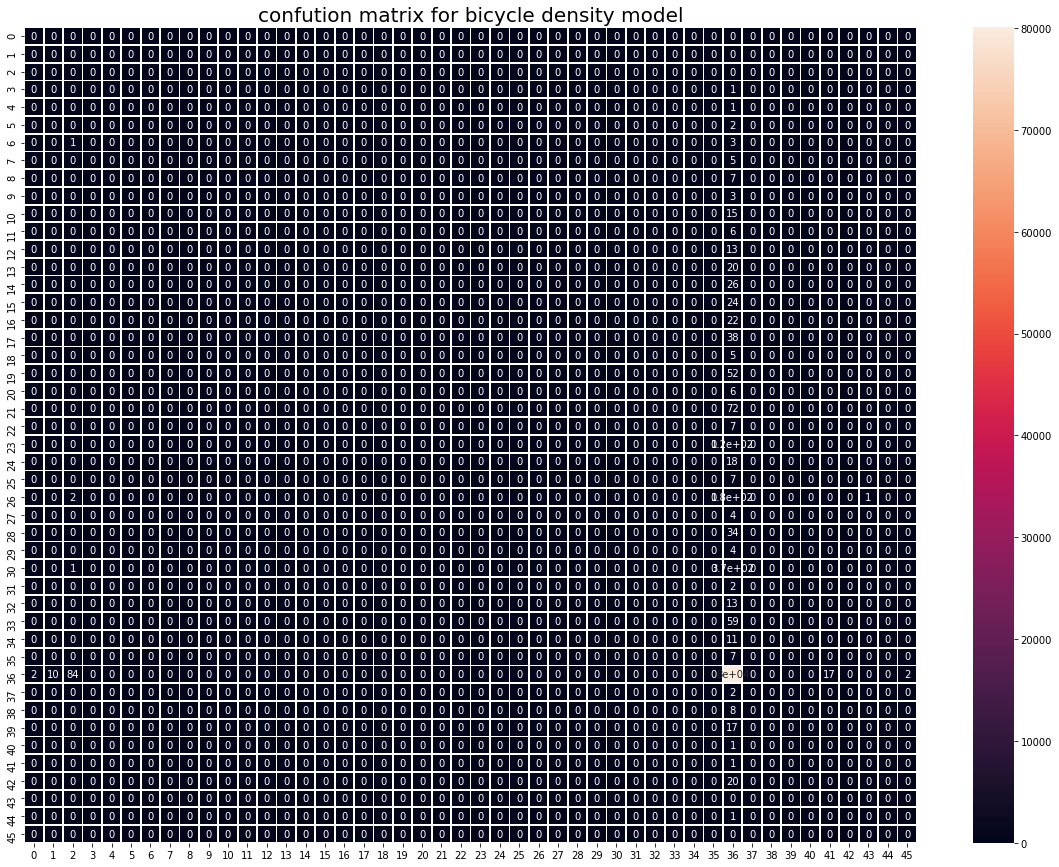

In [29]:
#### confution matrix for the bicycle densitdy model
heatmap_b, check_b = make_confution_matrix(log_bicycle_density_model['data'][-4], log_bicycle_density_model['data'][-3],"bicycle density model")


In [19]:
## recall and presicion for the pedestrian
print(check_b)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           8      0.000     0.000     0.000         1
           9      0.000     0.000     0.000         1
          11      0.000     0.000     0.000         2
          12      0.000     0.000     0.000         4
          13      0.000     0.000     0.000         5
          14      0.000     0.000     0.000         7
          15      0.000     0.000     0.000         3
          16      0.000     0.000     0.000        15
          17      0.000     0.000     0.000         6
          18      0.000     0.000     0.000        13
          19      0.000     0.000     0.000        20
          20      0.000     0.000     0.000        26
          21      0.000     0.000     0.000        24
          22      0.000     0.000     0.000        22
          23      0.000    

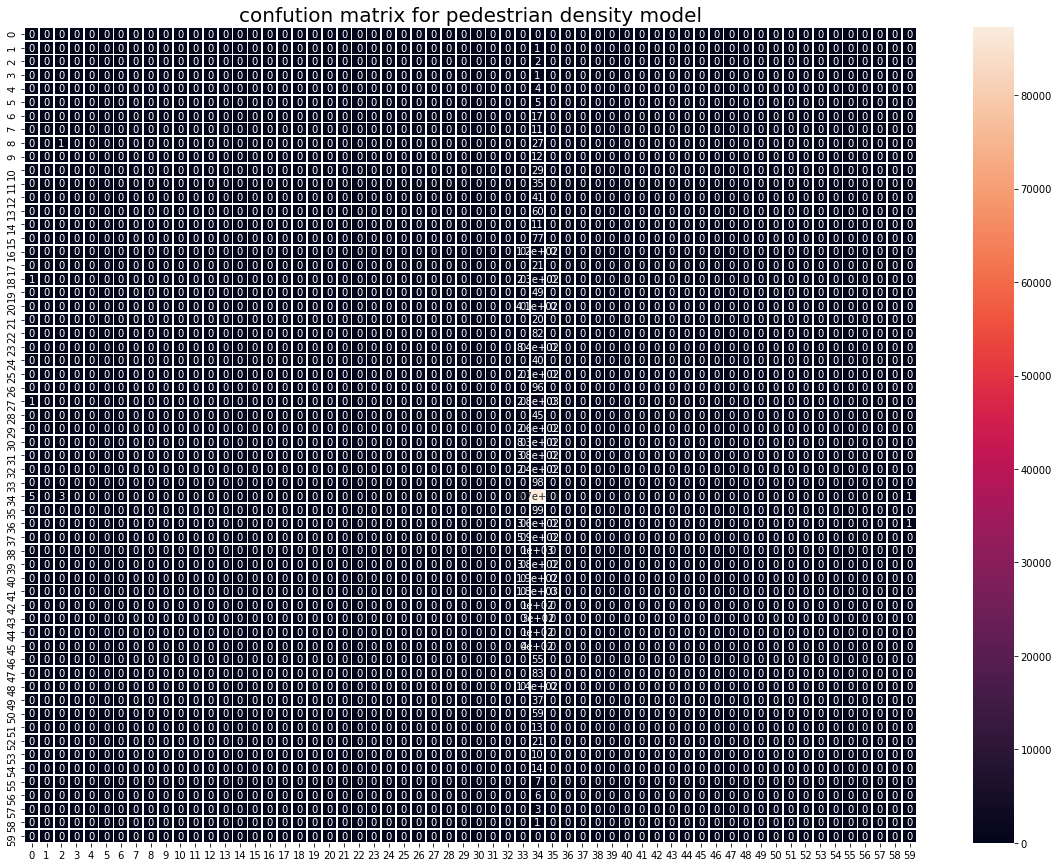

In [30]:
#### confution matrix for the pedestrian density model
heatmap_p, check_p = make_confution_matrix(log_pedestrian_density_model['data'][-4], log_pedestrian_density_model['data'][-3],"pedestrian density model")

In [21]:
## recall and presicion for the pedestrian
print(check_p)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.000     0.000     0.000         1
           4      0.000     0.000     0.000         2
           6      0.000     0.000     0.000         1
           7      0.000     0.000     0.000         4
           8      0.000     0.000     0.000         5
           9      0.000     0.000     0.000        17
          10      0.000     0.000     0.000        11
          11      0.000     0.000     0.000        28
          12      0.000     0.000     0.000        12
          13      0.000     0.000     0.000        29
          14      0.000     0.000     0.000        35
          15      0.000     0.000     0.000        41
          16      0.000     0.000     0.000        60
          17      0.000     0.000     0.000        11
          18      0.000     0.000     0.000        77
          19      0.000     0.000     0.000       121
          20      0.000    

## building the final product

In [22]:
### every segment_id has more then 1 distance because there is a slightly Differentiate 
###  in latitude and longitude of every obs so we are taking the mean in oreder to define distance for every segment id 
segments_data = new_data.groupby('segment_id').mean()
segments_data = segments_data.fillna(segments_data.distance.mean())### filling the NA observation because we added only 100 distances for the speed but if you want the full version you can delete the if in the distance function and delete this row
ids = segments_data['distance'].index
distances = segments_data['distance'].values



### building new dataframe for the comming months with all the segments in all the dates 
c = 24*7*3
dframe = pd.DataFrame()
dframe.loc[:,'hour'] = list([i for i in range(24)]*len(ids)*7*3)
dframe.loc[:,'day_of_week'] = list([i+1 for i in range(7)]*len(ids)*24*3)
dframe.loc[:,'month'] = list([i+9 for i in range(3)]*len(ids)*24*7)
dframe.loc[:,'year'] = list([2020 for i in range(1)]*len(ids)*24*7*3)
dframe.loc[:,'segment_id'] = list([i for i in ids]*c)

### adding new column with the avg distance we calculated above
dframe.loc[:,'distance'] = list([d for d in distances]*c)

### adding new column with the real segment Id' because we encoded it for the model 
dframe.loc[:,'real_segment_id'] = list(list(set(labelEncoder.inverse_transform(le_fitted)))*c)

### running the two models on the new data and saving the values in two new columns 
X_real = dframe[['year','month','day_of_week','hour','segment_id']]
dframe.loc[:,'predicted_bicycle_density'] = np.e**(((log_bicycle_density_model['model'].predict(X_real))/10)-4.3) # reversing the math munipulation we did on the modeling section 
dframe.loc[:,'predicted_pedestrian_density'] = np.e**(((log_pedestrian_density_model['model'].predict(X_real))/10)-3.7)#reversing the math munipulation we did on the modeling section

In [23]:
dframe

,hour,day_of_week,month,year,segment_id,distance,real_segment_id,predicted_bicycle_density,predicted_pedestrian_density
0,0,1,9,2020,0,121.487253,24420358,1.0,0.496585
1,1,2,10,2020,1,121.487253,261439495,1.0,0.496585
2,2,3,11,2020,2,121.487253,261439500,1.0,0.496585
3,3,4,9,2020,3,121.487253,285696013,1.0,0.496585
4,4,5,10,2020,4,56.450000,285696016,1.0,0.496585
...,...,...,...,...,...,...,...,...,...
1907635,19,3,10,2020,3780,121.487253,181460967,1.0,0.496585
1907636,20,4,11,2020,3781,121.487253,262946796,1.0,0.496585
1907637,21,5,9,2020,3782,121.487253,658427572,1.0,1.000000
1907638,22,6,10,2020,3783,121.487253,396599292,1.0,0.496585


In [24]:
#####  we reversed the log function so every obs with value zero became 1( because every num with exponent 0 is 1) so we reversed it back to 0  
dframe.loc[dframe['predicted_bicycle_density']==1,'predicted_bicycle_density'] = 0
dframe.loc[dframe['predicted_pedestrian_density']==1,'predicted_pedestrian_density'] = 0
#### new column, total density, which gets the sum of pedestrian density and bicycle density,
#### when pedestrian weight 4 times more becaese the avg speed of pedestrian is 6 kmh and bicycle is 24 kmh 
####  and devided by the dinstance in oreder to get the real density of the population in the area 
dframe['total_density'] = dframe['predicted_pedestrian_density']+dframe['predicted_bicycle_density']*0.25/dframe['distance']
#### deleting the encoded segment_id
dframe= removeCols(dframe, 'segment_id')
dframe

,hour,day_of_week,month,year,distance,real_segment_id,predicted_bicycle_density,predicted_pedestrian_density,total_density
0,0,1,9,2020,121.487253,24420358,0.0,0.496585,0.496585
1,1,2,10,2020,121.487253,261439495,0.0,0.496585,0.496585
2,2,3,11,2020,121.487253,261439500,0.0,0.496585,0.496585
3,3,4,9,2020,121.487253,285696013,0.0,0.496585,0.496585
4,4,5,10,2020,56.450000,285696016,0.0,0.496585,0.496585
...,...,...,...,...,...,...,...,...,...
1907635,19,3,10,2020,121.487253,181460967,0.0,0.496585,0.496585
1907636,20,4,11,2020,121.487253,262946796,0.0,0.496585,0.496585
1907637,21,5,9,2020,121.487253,658427572,0.0,0.000000,0.000000
1907638,22,6,10,2020,121.487253,396599292,0.0,0.496585,0.496585


In [25]:
#### values of the total density
set(dframe['total_density'])

{0.0,
 0.06081006262521796,
 0.0609351993396676,
 0.061079372025683934,
 0.061631136209529154,
 0.0618319502977142,
 0.06209124245956112,
 0.06274380602004433,
 0.06486713210063798,
 0.06833408237963326,
 0.06880231536864194,
 0.49658530379140947,
 0.4967152727256095,
 0.49679501042307816,
 0.49683369580010867,
 0.4974063773757207,
 0.49748752999742585,
 0.4976071914639057,
 0.49786648362575264,
 0.49851904718623585,
 0.49864753511944687,
 0.4987845301146664,
 0.49909331037621457,
 0.5006423732668295,
 0.5006825422715366,
 0.5007006516128852,
 0.5007373548264547,
 0.5010191011466899,
 0.5011091157728512,
 0.5011161915997252,
 0.501936438530541,
 0.5029354994920668,
 0.5034442168272024,
 0.5038031134395404,
 0.5041093235458247,
 0.5044676102007969,
 0.5045775565348335,
 0.5059548378252097,
 0.5061105973423956,
 0.5071359830504337,
 0.5074753323833263,
 0.5089999363861947,
 0.5108549964290937,
 0.5110209230876713,
 0.511364628309011,
 0.513361834324903,
 0.5166089047507405,
 0.5179898427

In [26]:
#### dividing the data into parts with very high total density,high, low, and none. The data gets a new column with the parts which tells the police where they need to reinforce due to high or low density of population. 
dframe.loc[dframe['total_density']>0.51,"police_reinforcement"] = "big reinforcements"
dframe.loc[(dframe['total_density']>0.5) & (dframe['total_density']<0.51),"police_reinforcement"] = "regular reinforcements"
dframe.loc[(dframe['total_density']>0.49) & (dframe['total_density']<0.5),"police_reinforcement"] = "small reinforcements"
dframe.loc[dframe['total_density']<0.49,"police_reinforcement"] = "no reinforcements"
dframe

,hour,day_of_week,month,year,distance,real_segment_id,predicted_bicycle_density,predicted_pedestrian_density,total_density,police_reinforcement
0,0,1,9,2020,121.487253,24420358,0.0,0.496585,0.496585,small reinforcements
1,1,2,10,2020,121.487253,261439495,0.0,0.496585,0.496585,small reinforcements
2,2,3,11,2020,121.487253,261439500,0.0,0.496585,0.496585,small reinforcements
3,3,4,9,2020,121.487253,285696013,0.0,0.496585,0.496585,small reinforcements
4,4,5,10,2020,56.450000,285696016,0.0,0.496585,0.496585,small reinforcements
...,...,...,...,...,...,...,...,...,...,...
1907635,19,3,10,2020,121.487253,181460967,0.0,0.496585,0.496585,small reinforcements
1907636,20,4,11,2020,121.487253,262946796,0.0,0.496585,0.496585,small reinforcements
1907637,21,5,9,2020,121.487253,658427572,0.0,0.000000,0.000000,no reinforcements
1907638,22,6,10,2020,121.487253,396599292,0.0,0.496585,0.496585,small reinforcements


In [27]:
### destribution of values in the police reinforcement column
dframe['police_reinforcement'].value_counts()

small reinforcements      1863522
no reinforcements           43611
regular reinforcements        354
big reinforcements            153
Name: police_reinforcement, dtype: int64